# DAE 9 Analysis of Variance (ANOVA)

author:
- |
    Sofia Dahl, sof@create.aau.dk\
    Dept. Architecture, Design and Media Technology, Aalborg University Copenhagen
---

## Learning goals

After working your way through this notebook you should be able to..
- Explain why one ANOVA is preferred to multiple t-tests
- Structure data in long and wide format required
- Perform and interpret a one-way ANOVA using available functions

## Table of Contents

- [1. Multiple comparisons](#MulitipleComp)
    - [1.1. ANOVA](#ANOVA)
    - [1.2. Assumptions for using ANOVA](#ANOVAassump)
- [2. Independent one-way ANOVA](#IndepANOVA)
   - [2.1 Defining model and reporting result](#Definemodel)
- [3. Setting up data](#Settingup)
- [4. Pairwise Contrasts](#contrasts)
- [5. One-way Repeated Measures ANOVA](#repANOVA)
    - [5.1 Within factors](#Withinfactors)
- [6. Several factors](#morefactors)

<a id= 'Descriptive'> </a>

In [56]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as stats

<a id= 'MulitipleComp'> </a>

## 1. Multiple comparisons
We frequently have more than two conditions we want to compare. For instance we might want to investigate guitarists preferesnces for guitar effects in a factorial design, where we might choose to compare 2 reverb settings x 3 levels of expertise (perhaps measured by Gold MSI).

Technically, we can compare for effects with pairwise comparisons using t-tests but it is a bad idea. The probability of  making a type I error is 5\%  ($\alpha$ =.05) for *each* test. The more comparisons we make, the higher the risk of finding a significant difference purely by chance

If three experimental groups have sample means from the same distributions, that is if $\mu_1$ = $\mu_2$ =$\mu_3$, we need to make three pairwise comparisons (1 versus 2, 2 versus 3, and 1 versus 3). The probability  of NO  Type I error is $(0.95)^3=0.86$ ($\alpha$ =.05). That is, the probability of making *at least* one Type I error when doing these three comparisons is $1-0.86=0.14$, or 14\%. 

There are two commonly used ways to get around this problem. If multiple t-tests are used, the $\alpha$-level can be adjusted so that each test is more strictly performed. Typically such a *Bonferroni* correction is used to compensate for the increased probability of Type I errors when doing multiple t-tests. But a better approach is to do ONE test that looks for an overall effect, and drop all the pairwise comparisons being the source of the increased Type I error risk. This is what ANOVA does.

### Try out 1:
How large probability of making  *at least* one Type 1 error is there for pairwise testing 
 with five experimental groups?

<a id= 'ANOVA'> </a>

### 1.1. ANOVA

A better approach is to perform one test that includes all categories and factors at once. A very commonly used test is Analysis of Variance (ANOVA). There are many different kinds of ANOVAs, those that are intended for repeated measurements and multiple factors (for instance, there might be several levels of auditory and visual feedback in the example above, or perhaps you would like to include the age and handedness as a factor that might influence performance). The general principle, however, is to compare the variance between different groups (i.e. conditions or  treatments) with the variance occurring within each group.

$$F  =\frac {variance -between - treatments} {variance - within-  treatments} =\frac {variance_{explained}} {variance_{unexplained}} $$

Hopefully the talk of variance now rings a bell, because again the sum of squares are at the basis of these calculations. In the Inferental chapter we calculated the effect size from the ratio between the model $ SS_M$ and the total $SS_T$ sum of squares. The F statistic is essentially ratio between the explained variance of the model $SS_{M}$ and the residual variance $SS_{Res}$:
$$\frac {SS_{M}} {SS_{Res}}$$


The model in the case of ANOVA is a bit more complex in that we typically have more means than two to do the sum of squares for (one for each treatment /group). Because we calculate this for the full model at once, the test itself cannot say if ALL or just ONE of the groups differ significantly. For this we need to make follow-up comparisons that *contrasts* the different groups (just as you would in t-tests). These contrast tests can be *planned* already at the start of the experiment, or *post-hoc*, after the ANOVA has been run. In both cases, precautions againt multiple tests have to be taken, for instance by dividing the significance level by the number of tests done as (Bonferroni correction). 

So when reporting results from an ANOVA, we would both report the results from the overall test on the full model, but also the results of the follow-up pairwise comparisons. Some software reports these contrasts, perhaps even using different tests. Which ones to report depend a bit. 


### Try out 2:
Consider that you have data from 4 groups like in the code below and that an ANOVA shows a significant effect. How many pairwise comparisons should you plan to detect *which* differences between the groups that causes the overall effect?

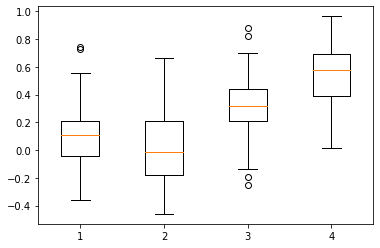

In [57]:
#We generate four randomly drawn samples from  normally distributions 

K=40 #variable for sample size
score1=np.random.normal(0.025,0.25,K)
score2=np.random.normal(0.01,0.25,K)
score3=np.random.normal(0.3,0.25,K)
score4=np.random.normal(0.56,0.25,K)

plt.boxplot([score1,score2, score3,score4])
plt.show()


<a id= 'ANOVAassump'> </a>

### 1.3 Assumptions for using ANOVA
In order for an ANOVA to show the correct result, data must fulfill the assumptions for parametric data. 
That is
- interval or ratio data
- equal variance (homogeneity of variance)
- normality

In ANOVA and multiple regression, it is  more the *residuals* (the unexplained variance) that must fulfill these criteria, and some statistic software report the diagnostics for this with the model statistics.  The basis is the same, however, and it is generally a good idea to check for 

Similar to t-test, we also need to know whether the data points are *related* or *unrelated*. That is, if you have different groups of participants testing the different effects or controllers, the data points are clearly independent observations. If you choose to set up your experiment with the same participants in all the groups, several observations will be from the same person and are therefore dependent. In this case, there is an additional assumption of *sphericity*, or that variances of tifferences between condition levels are equal.  

<a id= 'IndepANOVA'> </a>

## 2. Independent one-way ANOVA


When comparing two different groups, as in a between groups design, the
samples from the two groups should be independent.

Let us take the example of a digital instrument played using different controllers. One group played using mouse and keyboard ("Mouse"), while two other groups tested other controllers ("Control1" and "Control2"). Is there a difference in the dependent variable (e.g. their score or rating) depending on the controller used?

We can set up the null and alternative hypothesis

- H0: There is no significant difference in scores between the different controllers. 
- H1: There is a significant difference in scores between the different controllers.

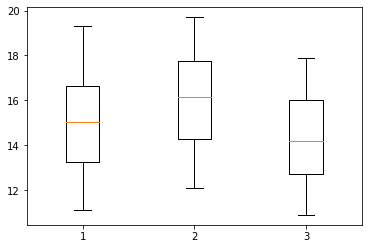

In [115]:
# Data for different controllers
data= pd.DataFrame([[ 13.5, 14.6, 12.7],
    [14.6, 15.6, 13.4],
    [ 12.7, 13.6, 12.1],
    [ 15.5, 16.7, 15.0],
    [ 11.1, 12.1, 10.9],
    [ 16.4, 17.6, 15.7],
    [ 13.2, 14.2, 12.8],
    [ 19.3, 19.5, 17.9],
    [ 16.7, 17.8, 16.1],
    [ 18.4, 19.7, 17.9]], columns=(["Mouse","Control1","Control2"]), index=[1,2,3,4,5,6,7,8,9,10])

# We first look at the data 
plt.boxplot([data.Mouse,data.Control1,data.Control2])
plt.show()

We need to test the assumptions of course. The box plot looks promising with respect to equal variance, but we should do the test nonethe less. We also check for normality.

In [22]:
# The Levene variance test tests the null hypothesis that 
# all samples come from populations with equal variances
stats.levene(data.Mouse,data.Control1,data.Control2)

LeveneResult(statistic=0.005508899933893261, pvalue=0.9945073637505352)

In [19]:
#To test the null hypothesis that the data was drawn from a normal distribution
#we start with Shapiro-Wilks test: 
stats.shapiro(data.Mouse), stats.shapiro(data.Control1), stats.shapiro(data.Control2) 

((0.9758615493774414, 0.9392507076263428),
 (0.9418976902961731, 0.5743166208267212),
 (0.9367671012878418, 0.5176321864128113))

None of the above tests indicate that we should reject the null hypothesis as they 
show p-values > 0.05. Which is good for us wanting to use parametric tests. It seems promising to proceed to the actual test.



<a id= 'Definemodel'> </a>

### 2.1 Defining model and reporting result

We are now ready to define the model we want to test as our dependent variable "Score" and the independent "Controller". 

For the one-way independent ANOVA we can enter the dependent and independent variable in the function and get the F-statistic and probability out:

In [23]:
F, p = stats.f_oneway(data.Mouse,data.Control1,data.Control2)
print('F statistic = {:5.3f} and probability p = {:5.3f}'.format(F, p)) 

F statistic = 1.128 and probability p = 0.339


Based on this result, we retain the null hypothesis, because the probability of obtaining our results by random is not below our criterion ($\alpha <0.05$) 

To report the result of an ANOVA we will need the F-statistic, probability and also the degrees of freedom. Unlike the t-test, we now have several means that are estimated and recuding our degrees of freedom, and we report two kinds: One for the effect of the model ($df_M$) and  one for the residuals of the model ($df_R$). 


$df_M$, calculated as the number of factors/groups k - 1 
$df_R$, calculated as the number of observations N -k

In our example, we have 3 controllers,  which leads to $df_M=3-1=2$
and a total of 30 observations (10 for each controller), which yields $df_R=30-3=27$.

And so we are ready to report:

"A one-way independent ANOVA showed no main effect of controllers on participants' scores, F(2,27)=1.128, p>0.05)."


### Try out 1: 
Add a fourth group by copying the data of Controller 1 and modifying by reducing 3.5 overall. Would you say from the box plot, that it is likely to be an overall difference between groups now?

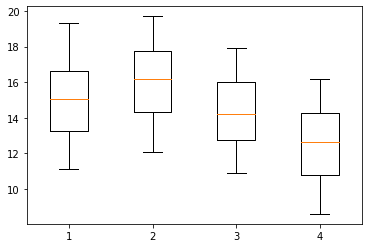

In [105]:
#adding fourth controller
data['Controller3']=data.Control1-3.5

# plot the data 
plt.boxplot([data.Mouse,data.Control1,data.Control2,data.Controller3])
plt.show()

### Try out 2: 
Redo the one-way anova analysis with the new controller. Would you still retain the null hypothesis?

In [108]:
#F, p = stats.f_oneway(data.Mouse,data.Control1,data.Control2,data.Controller3)


Even if the anova shows a *main effect* we do not know WHICH of the controllers that actually cause the difference in scores. A bit further on we will look do some paired comparisons. 

### 2.2. Effect size One-way Independent ANOVA

Like in other tests, it is good practice to investigate and report the effect size. 


As suggested in Fields & Hole, it is possible to calculate $r^2$ (and then r) from the sum of squares 

$$r^2 =\frac {SS_{M}} {SS_{T}}$$

Where $SS_{M}$ is the sum of squares for the model and $SS_{T}$ is the total sum of squares.

But, as also is explained in Fields & Hole, it is better to use the more accurate measure $\omega$ based on the mean squared like this

$$\omega^2 =\frac {MS_{M}-MS_{R}} {MS_{M}+((n-1)\times MS_{R})}$$

where $MS_{M}$ is the mean squares of the model, $MS_{R}$ is the mean residual squares, and n is the number of participants/observations in a group.

Both Sum of squares and Mean squares are reported by some software (e.g. SPSS). Unfortunately, these measures are not readily available from the f_oneway output so we would have to calculate them separately.

<a id= 'Settingup'> </a>

## 3 Setting up data
Doing ANOVA analysis may involve setting up data in a different way so that the functions can read and interpret the data properly. 

In some cases we have *wide format* where the dependent variable for each condition is collected in columns for each participant:

|Participant|DVCase1 |DVCase2|DVCase3|
|-----|-----|--------|-----|
|1   |71   |72      |70  |
|2   |61   |73      |71  |
|:  |:     | .       |  .  | 

And in other cases we use *long format*, where the dependent variable is displayed in one columns over several rows:

|Participant|Condition |DVScore|
|-----|-----|--------|
|1   |Case1  |71|
|1   |Case2  |72 |
|1   |Case2  |70 |
|2   |Case1  |61|
|2   |Case2  |73 |
|2   |Case2  |71 |
|:  |:     | .   |  


Many softwares/function will expect data to be in one or the other format. Specifically for repeated measures analysis, *pivot table*, that contains means or other summaries of the data  are often required.
https://en.wikipedia.org/wiki/Pivot_table

Switching bewteen these data table formats can be a pain. A great tip is to consider the software and functions you will use already before actual data collection. In this way you can save data in the proper way already from the beginning (and save lots of time).

In [109]:
#To simplify this transition, we will add a variable "id" to denote each participant
data["id"] = data.index

#now we conform to "long" format using the pandas function "melt"

longdata=data.melt(id_vars=['id'], value_vars=['Mouse', 'Control1', 'Control2'], var_name='Controller', value_name='Score')
#longdata #instead of 10 rows, you should now have 10 x K rows  (K controllers) 

We now have the *long* format and, because we only have one factor this conversion was not too complicated. But often there might be many independent and dependent variables in one data frame, as well as other factors (e.g. particpants' age, how trained musicians they are etc) and in these cases the conversion between long and wide format can quickly become cumbersome.


### Try out 3: 
Reshape the data into long format including the fourth group, (with the added Controller3). Name the reshaped data "longerData".
How many rows should you expect?

In [ ]:
#add the additional controller among the value_vars

#longerData=data.melt(id_vars=['id'], 
#        value_vars=['Mouse', 'Control1', 'Control2'], #add the additional controller here
#        var_name='Controller', value_name='Score')

#longerData.shape() 

<a id= 'contrasts'> </a>

## 4. Pairwise Contrasts

As discussed abover, our task is not quite done with the ANOVA output table. A main effect should be investigated to sort out *which* of the groups that contributed toward it. 

Here we will not go into details about what tests that are best to use where. For pairwise post-hoc (not planned beforehand) the more commonly used ones are Bonferroni and Tukey HSD test.  


In [116]:
import statsmodels.stats.multicomp as ml

# Note that data needs to be long format for the MultiComparison function

mcobj = ml.MultiComparison(longdata.Score,longdata.Controller)    #create multicomparison object


out = mcobj.tukeyhsd(0.05) #Tukey HSD test on object, using significance level 0.05

print(out)

  Multiple Comparison of Means - Tukey HSD, FWER=0.05  
 group1   group2  meandiff p-adj   lower  upper  reject
-------------------------------------------------------
Control1 Control2    -1.69 0.3102 -4.4952 1.1152  False
Control1    Mouse     -1.0 0.6458 -3.8052 1.8052  False
Control2    Mouse     0.69 0.8022 -2.1152 3.4952  False
-------------------------------------------------------


In the output we see the mean difference between the contrasted groups, the probability (p-adj), upper and lower confidence as well as a out-of-the box recommendation on whether the null hypothesis should be retained or rejected. With the three original groups (Mouse, Control1, Control2) the "False" in the last column says that H0 cannot be rejected for any of the comparisons. This because the probability is higher than 0.05.

### Try out 4: 
Redo the post-hoc comparisons on longerData (with the added fourth controller). Reflect on the output and compare to the boxplots earlier. Is the result as you expected?

In [ ]:
#mcobj = ml.MultiComparison(longerData.Score,longerData.Controller)    #create multicomparison object

#out = mcobj.tukeyhsd(0.05) #Tukey HSD test on object, using significance level 0.05


<a id= 'repANOVA'> </a> 

## 5.  One-way Repeated Measures ANOVA
In many cases, we ask the same participant to participant in all the conditions because this reduces the effect of individual variability (as discussed in the chapter on Designing Experiments). 
If now the data in our tests had *not* been collected from three independent groups of participants we will not get the correct result in our analysis from an independent ANOVA. 

Whenever we have the same participant playing three instruments/games with different controllers, the data points are *related* because we repeated our measure for the same person. We will therefore use a repeated measures ANOVA.

This also means that we are making an additional assumption about sphericity. Fields & Hole refer to Mauchly's test that is reported in SPSS and R. To be honest, there is better support for repeated measures analysis in both R and SPSS compared to python so it is probably worth to investigate if you plan on collecting data for within-group design (see also https://danvatterott.com/blog/2016/02/28/repeated-measures-anova-in-python-kinda/ ). But we will look at one example without assumption testing.

<a id= 'Withinfactors'> </a>

### 5.1 Within factors

The model we set up for repeated measures ANOVA is very similar,

Score ~ Controller

but now we must also define a *within* factor. The software does not typically keep track of this unless we define it. In our example case, the within factor is the different controllers. That is, instead of having different groups contrasted, we now need to compare each individual participant's score in the different cases.

Even though most software would require an aggregated pivot table for repeated measures ANOVA (RM-ANOVA), we get around this here, by using a particular class AnovaRM from Statmodels where this aggregation is taken care of.


In [114]:
from pandas import pivot_table                 #this does the pivot table
from statsmodels.stats.anova import AnovaRM    #required by AnovaRM

# the anova object
aov = AnovaRM(
    longdata,                   #dataframe
    depvar='Score',             #dependent variable
    subject='id',               #subject identifier (participant number in this case)
    within=['Controller'],      #within-subject factor, here the different controllers
    aggregate_func='mean'       #if more than one observation per participant
)
res=aov.fit()                  # the fit of model
print(res)                     #printing the results

                  Anova
           F Value  Num DF  Den DF Pr > F
-----------------------------------------
Controller 141.3698 2.0000 18.0000 0.0000



<a id= 'morefactors'> </a> 

## 6. Several factors
The above examples are quite simple with only one factor (one-way). If we have more than one factor, we would have factorial ANOVA. This could, for instance have an additional hypothesis, that the scores might be affected by the type of instrument that participants were trained on. To investigate this, we add and additional independent variable "Instrument" where participants were recruited among different groups of instrumentalists. If we include three controllers and three different instrumentalists we would have a 2-way ANOVA. In addition to any *main effect* of instrument group or controller, it is also likely that we would like to investigate the  *interaction effects* where there is effect of the controller and instrument *combined*. This would be called a factorial 3 $\times$ 3 ANOVA.

There are two things to keep in mind when designing these kinds of studies:
- The more factors you involve, the more difficult it will be to interpret any interaction effects.
- The more factors, the more participants are needed in between-group studies.

With respect to participants, it could make sense to have the controller as a within factor, and have all participants from the three groups of instrumentalists try all kinds of controllers. This would be a 2-way Mixed ANOVA. 

As you probably have gathered by now, there are many different possibilities, and many things to be cautious about when setting up your test. You will have to consult other books for the details on these statistical methods. And when you do, also do yourself the favor of investigating that you are able to conduct the analysis (including assumptions check) within the software.